<a href="https://colab.research.google.com/github/DrLux/CartPole-v1-/blob/master/REINFORCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solving CartPole-v1 environment using REINFORCE implementation from scratch.

In [0]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1


In [0]:
from pyvirtualdisplay import Display
import gym
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
from gym.wrappers import Monitor
import numpy as np
import random
import scipy.stats

from gym import logger as gymlogger

np.random.seed(1)


In [0]:
#Stampa a schermo il video 
def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = max(mp4list) #prendo l' ultimo video
    print(mp4list)
    print(mp4)
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

#Crea un dump video dell' episodio 
def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [0]:
"""Using with softmax policy"""
  
class Actor(object):
    def __init__(self, state_size, action_size, alpha = 0.01, gamma = 0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.rewards = []
        self.grads = []
        self.theta = np.random.rand(state_size, action_size) #vettore dei pesi
        self.alpha = alpha
        self.gamma = gamma
        
    # Vectorized softmax Jacobian
    def softmax_grad(self,softmax):
      s = softmax.reshape(-1,1)
      return np.diagflat(s) - np.dot(s, s.T)
    
    def compute_gradient(self, probs, state, action):
        dsoftmax = self.softmax_grad(probs)[action,:]
        dlog = dsoftmax / probs[0,action]
        grad = state.T.dot(dlog[None,:])
        return grad

    def store(self, probs, state, action, reward):
        grad = self.compute_gradient(probs, state, action)
        self.grads.append(grad)
        self.rewards.append(reward)
        

    # create a distribution over all actions
    def get_probabilities(self, state):
      z = state.dot(self.theta)
      exp = np.exp(z)
      return exp/np.sum(exp)


    def update(self):
      for i in range(len(self.grads)):
        self.theta += self.alpha * self.grads[i] * sum([ r * (self.gamma ** t) for t,r in enumerate(self.rewards[i:])])
      self.grads = []
      self.rewards = []
	

        

In [0]:
class Agent:
  env = None
  
  def __init__(self, env):
    self.env = env
  
  def statistics(self):      
    plt.title("Reinforce")
    plt.plot(np.arange(self.max_episodes), self.episode_rewards)  
    plt.xlabel('Episodes')
    plt.ylabel('Cumulative Rewards')
    plt.show()
    
  def training(self, max_episodes,max_steps,alpha = 0.01, gamma = 0.99):
    state_size = self.env.observation_space.shape[0]
    action_size = self.env.action_space.n
    g = Actor(state_size, action_size,alpha = 0.01, gamma = 0.99)
    self.episode_rewards = [] # Keep stats for final print of graph
    self.max_episodes = max_episodes
    
    
    for episode in range(max_episodes):
      steps = 0
      score = 0 # Keep track of game score to print
      state = self.env.reset()[None,:] #transform the vector shape (N,) into (1, N)
      done = False     
      
      while (not done): #for every steps till the end of the episode
        probs = g.get_probabilities(state) #get probabilities distribution over the actions from the Actor module
        action = np.random.choice(action_size,p=probs[0]) 
        next_state, reward, done, info = env.step(action)  
        next_state = next_state[None,:]
        score += reward
        
        g.store(probs, state, action, reward) #save all transiction of the current episode
        state = next_state
        steps += 1
        
        if (steps % max_steps == 0): #seems that perform update during (not only at the end) of the episodes improves performance
          g.update()      

      g.update()
      self.episode_rewards.append(score) 
      print('Episode: {} Score: {}'.format(episode, score))
  
             

In [0]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1


In [0]:
!rm -rf video

display = Display(visible=0, size=(400, 300))
display.start()
env = wrap_env(gym.make("CartPole-v1"))


Episode: 0 Score: 29.0
Episode: 1 Score: 70.0
Episode: 2 Score: 34.0
Episode: 3 Score: 13.0
Episode: 4 Score: 40.0
Episode: 5 Score: 20.0
Episode: 6 Score: 101.0
Episode: 7 Score: 47.0
Episode: 8 Score: 68.0
Episode: 9 Score: 50.0
Episode: 10 Score: 115.0
Episode: 11 Score: 103.0
Episode: 12 Score: 71.0
Episode: 13 Score: 56.0
Episode: 14 Score: 66.0
Episode: 15 Score: 76.0
Episode: 16 Score: 169.0
Episode: 17 Score: 75.0
Episode: 18 Score: 69.0
Episode: 19 Score: 81.0
Episode: 20 Score: 76.0
Episode: 21 Score: 117.0
Episode: 22 Score: 87.0
Episode: 23 Score: 67.0
Episode: 24 Score: 71.0
Episode: 25 Score: 52.0
Episode: 26 Score: 74.0
Episode: 27 Score: 78.0
Episode: 28 Score: 84.0
Episode: 29 Score: 64.0
Episode: 30 Score: 56.0
Episode: 31 Score: 153.0
Episode: 32 Score: 127.0
Episode: 33 Score: 83.0
Episode: 34 Score: 117.0
Episode: 35 Score: 78.0
Episode: 36 Score: 64.0
Episode: 37 Score: 104.0
Episode: 38 Score: 75.0
Episode: 39 Score: 90.0
Episode: 40 Score: 66.0
Episode: 41 Score

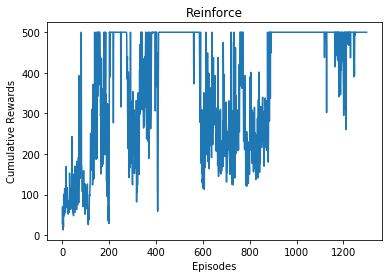

In [11]:
a = Agent(env)
a.training(1300,200,alpha = 0.1, gamma = 0.99)
a.statistics()

In [12]:
display.stop()
env.close()
show_video()

['video/openaigym.video.0.134.video000512.mp4', 'video/openaigym.video.0.134.video000343.mp4', 'video/openaigym.video.0.134.video000000.mp4', 'video/openaigym.video.0.134.video000008.mp4', 'video/openaigym.video.0.134.video000027.mp4', 'video/openaigym.video.0.134.video000001.mp4', 'video/openaigym.video.0.134.video000729.mp4', 'video/openaigym.video.0.134.video000216.mp4', 'video/openaigym.video.0.134.video001000.mp4', 'video/openaigym.video.0.134.video000064.mp4', 'video/openaigym.video.0.134.video000125.mp4']
video/openaigym.video.0.134.video001000.mp4
